# SARIMA Vs Seasonal VAR for Weather Forecasting Dashboard in AWS


## Author: David Thorne, Thorneinsight@gmail.com

## Project Goals: 
    
###   &emsp; Yearly temperatures are a great way to get into time series modeling due to the clear seasonality. Hourly temperatures are more unpredictable, but a more useful thing to predict, as they can be used for weekly weather forecasts. SARIMA on its own can likely produce a general idea for weekly temperatures, but may not be able to account for "unpredictable" fluctuations. A Seasonal VAR on the other hand may be more robust to these fluctuations because other weather conditions outside of temperature are modeled as well.  In this project I set out to create a full stack weather application run entirely using Amazon Web Service (AWS) services that could forecast daily temperatures using both models described. I also attempted to see if VAR forecasted weather conditions could predict rain, the hope being that maybe a multivariate time series would be able to forecast a convergence of weather conditions (temp, pressure, humidity) that could increase rain likelihood.



    
    
## Data Aquisition:
* I purchased 40 years of weather data of a location nearby me from https://openweathermap.org/. Every hour a crontab tells a script to run in my Linux EC2 server that makes an API call to openweathermaps for the next batch of hourly data, which it then sends to my RDS database using PyMySQL.

## Cleaning:
* Every time the API request is made, the data has to be processed to fit in my RDS database, which involves removing units and changing date formats, and creating a pandas dataframe before using my PyMySQL connection to execute the query. When data is pulled from the database my script trains the models and makes forecasts, I only have to change it in that I set the index to the be the dates.


## AWS Architecture and Deployment
* The cloud services used for this full stack web app are EC2, RDS, and S3 instances. Inside an EC2 server are two scripts activated by Linux crontabs and one flask app. One of these scripts runs in a Docker container. Within these scripts, PyMySQL and Boto3 are used to communicate to the RDS database and S3 storage respectively. 

* One script makes an API request to https://openweathermap.org/, cleans the data, and uses PyMySQL to enter it into the RDS database. It is executed every hour.

* The next script is containerized; a Docker image was made for this script. This script does most of the heavy lifting. It uses PyMySQL to grab all of the data from the RDS database, then trains the SARIMA and SVAR models to forecast weather for the next week (as well as the previous week to display the model performance of the previous week), and then saves forecast plots to an S3 bucket. Every time the script is run, it also clears the bucket. The idea of using the bucket is to accumulate previous forecasts and performance visuals for quick displaying of these analyses should I want to. This script runs every week.

* The last script is my flask app, which serves using gunicorn to my ec2 server’s public IP. It calls on an html file that I wrote which displays all of the plots that are made as a weather forecast dashboard. The images called on within the html file are all links to images in my S3 bucket, which are updated every time the training/forecasting/plotting script has run. A timestamp is added to the links within the html file, to avoid the page failing to reload because it thinks it already has the linked image. The app never has to restart since the images are links with timestamps to my S3 bucket.


## Feature Creation:

* I created wind direction features as well as rates of change of temperature, pressure, humidity, wind speed and direction, however not all features proved useful to all of the models throughout the project, as they were weeded out with filter and wrapper methods.






## Model:
* SARIMA and a Seasonal VAR model were used to forecast hourly temperatures out to a week. The VAR model performed best with the other endogenous variables pressure, humidity and wind speed. ACF and PACF analyses were performed as well as auto arima to determine the best parameters for these time series : (18,0,12)(4,1,2, 24).




## Issues with training:
* I was not able to train SARIMA with the same amount of data as the SVAR model on my personal computer due to hardware constraints, which could give VAR an unfair advantage. 

## Results:
* SARIMA Average RMSE (Kelvin) : 5.897
* VAR Average RMSE (Kelvin) : 5.607
* KNN f1 score fore rain classification: 0.62
* It was not possible to use forecasted data is input to another model forecast rain likelihood with any desirable f1 score.



## Website:
* Come check out the website: http://3.227.234.200:8080/   

## Files
* Within the GitHub Repo you will find A notebook for the development process of the whole project, another notebook used to showcase the containerized script that does the heavy lifting for the app, a .py file for the flask script, a  .py file for the script that updates RDS with current weather conditions every hour, and folders for templates and backgrounds. There is also a folder with the Dockerfile and requirements.txt.


## Discussion:
*  A Seasonal VAR model managed to outperform SARIMA modeling only temperatures. This is an interesting result, but it is clear that hourly weather conditions are influenced by factors not explained by time series alone as I’ve built them, and multivariate VAR only helps slightly to account for them. The KNN model was able to classify rainy conditions with a decent f1 score. I am happy to see that the multivariate model was able to outperform SARIMA, especially because currently there is no package in statsmodels for seasonal VAR and I had to transform the data back and forth on my own.

* The f1 score for classifying rain conditions from forecasted data was very poor. The hope was that a multivariate time series may be able to forecast a convergence of weather conditions (temp, pressure, humidity) that could cause rain. The conditions for rain are very specific, and hourly temperatures are prone to shifts not explained by time series alone.  Therefore a time series alone as I’ve built it does not show much potential for forecasting weather condition events outside of general conditions like temperature and humidity.



###  Importing data, cleaning missing values, and setting index as a datetime value.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error
import math
import numpy as np

df = pd.read_csv(r'C:\Users\Dave\Desktop\datadata\AWS\historical bulk plymouth.csv')
df = df.drop(columns=['city_name', 'visibility', 'dew_point', 'sea_level', 'grnd_level', 'wind_gust']) 
df['rain_1h'].fillna(.00000000000001, inplace=True) #to do certain operations that dont like 0
df['dt_iso'] = df['dt_iso'].apply(lambda x: x.replace("+0000 UTC",'')) #removing that part for the index
df.set_index('dt_iso', inplace=True)
df.index = pd.DatetimeIndex(df.index)
# df['wind_NS'] = np.sin(np.deg2rad(df['wind_deg'])) #giving directionn to wind as new features
# df['wind_EW'] = np.cos(np.deg2rad(df['wind_deg']))
print(df.head())

                            dt  timezone        lat        lon    temp  \
dt_iso                                                                   
1979-01-01 00:00:00  283996800    -18000  41.672042 -73.052885  277.32   
1979-01-01 01:00:00  284000400    -18000  41.672042 -73.052885  277.56   
1979-01-01 02:00:00  284004000    -18000  41.672042 -73.052885  277.85   
1979-01-01 03:00:00  284007600    -18000  41.672042 -73.052885  279.64   
1979-01-01 04:00:00  284011200    -18000  41.672042 -73.052885  279.54   

                     feels_like  temp_min  temp_max  pressure  humidity  ...  \
dt_iso                                                                   ...   
1979-01-01 00:00:00      274.23    274.60    277.92      1030        96  ...   
1979-01-01 01:00:00      274.28    274.60    278.13      1029        96  ...   
1979-01-01 02:00:00      274.48    277.85    277.85      1029        96  ...   
1979-01-01 03:00:00      276.60    276.30    280.18      1028        97  ...   
1

### Out of the features above, I have focused on temperature, pressure, humidity, wind speed, and features derived from those, since they are numeric and have previously been shown to have seasonality as well as correlation between each other that is useful for weather forecasting.

### Let's look at the temperatures on a yearly scale

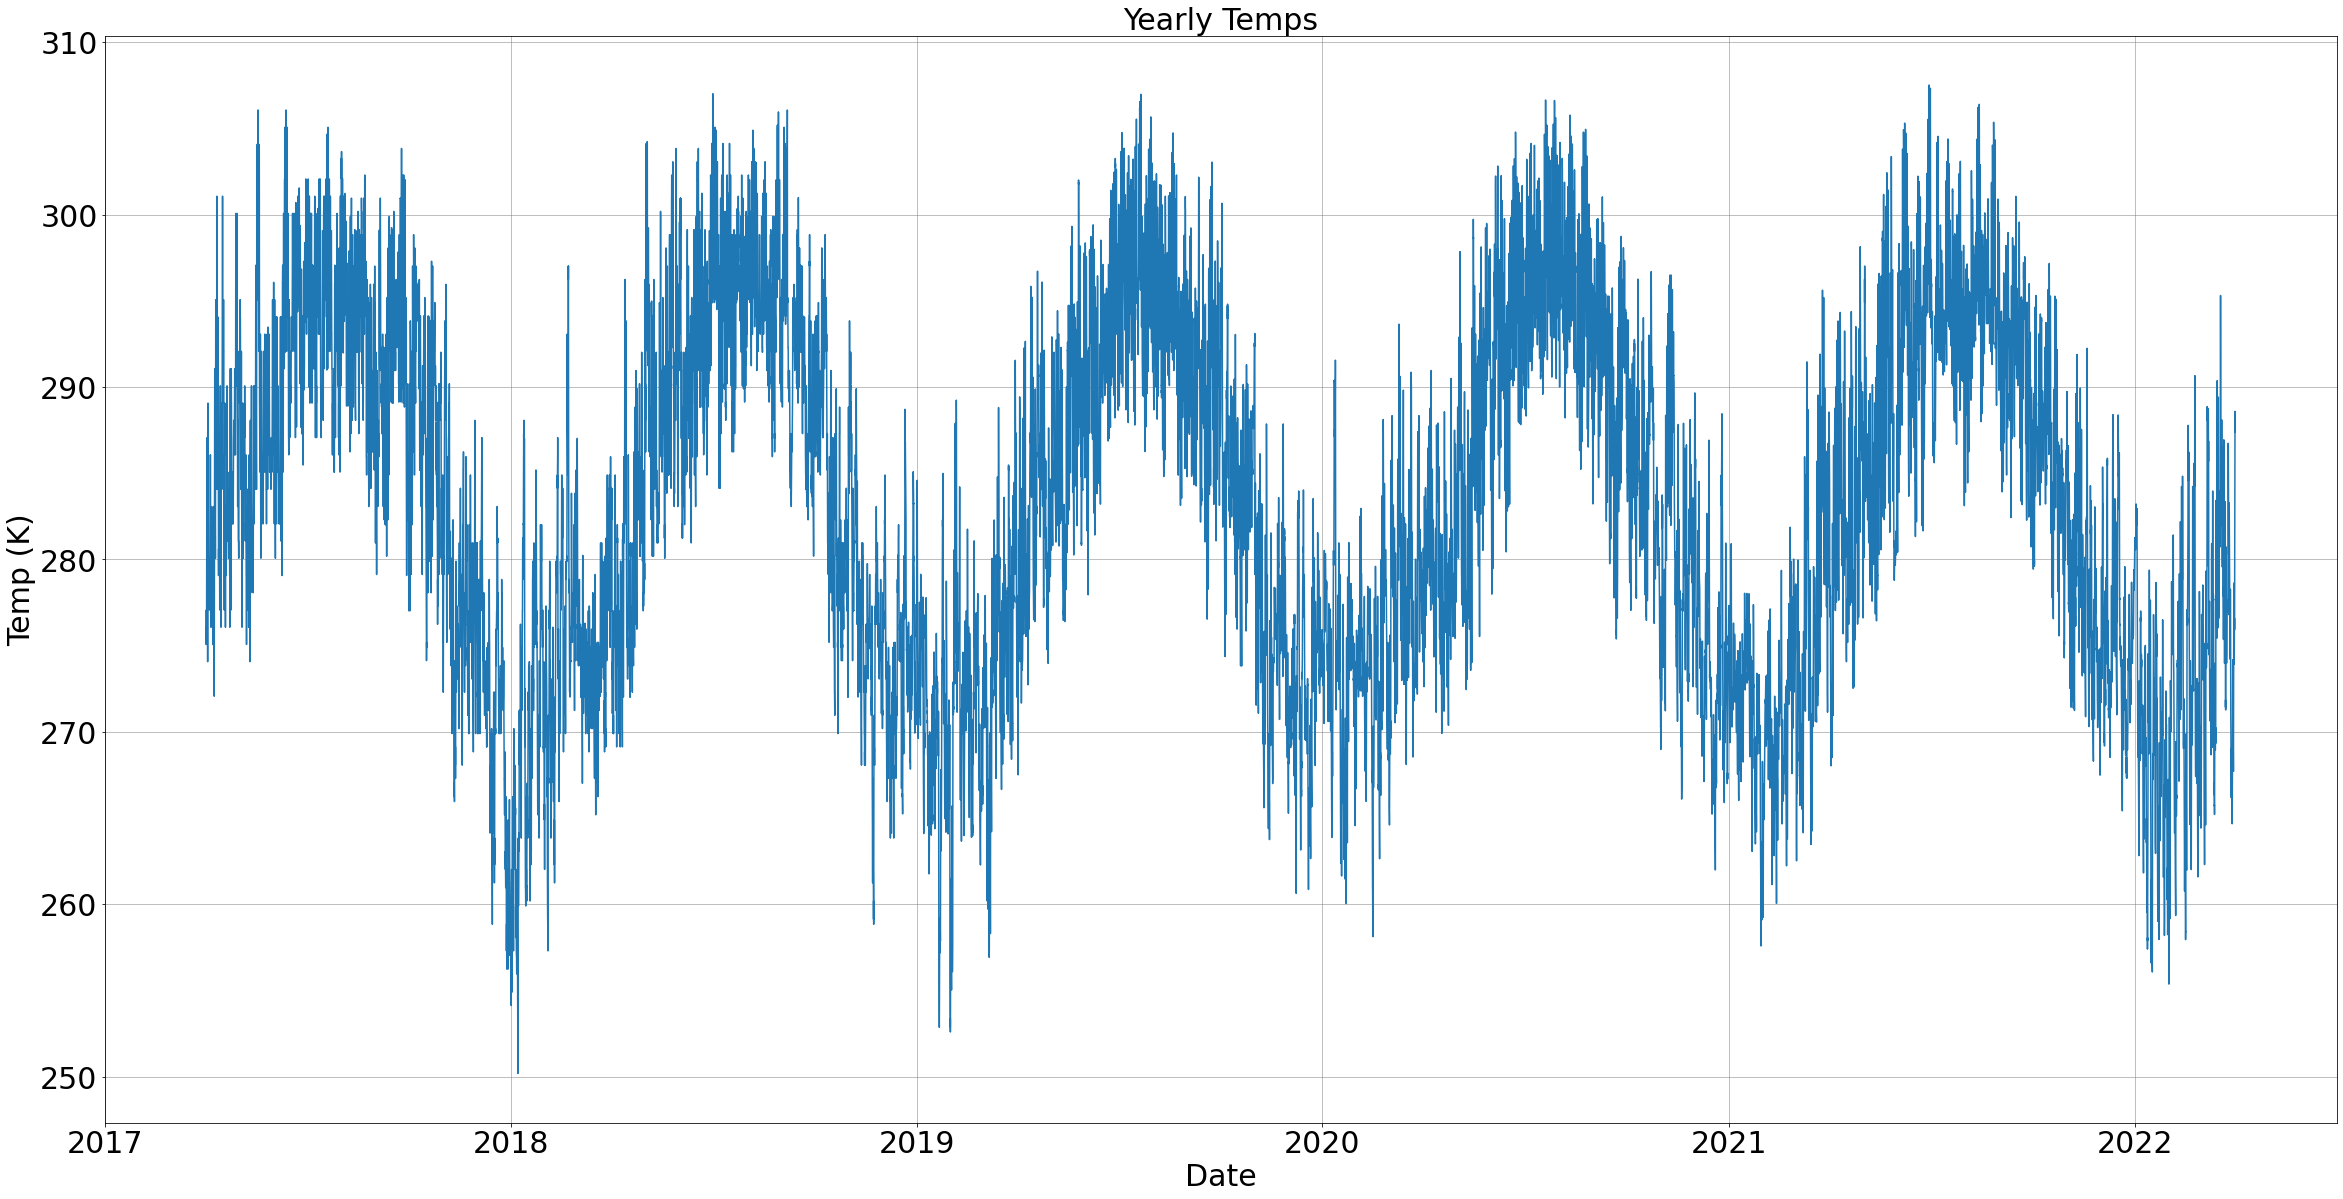

In [2]:
fig, ax = plt.subplots(1,1, figsize=(40, 20))
ax.plot(df.tail(8760*5).index.values, df['temp'].tail(8760*5)) #8760 hours in a year
ax.set_title('Yearly Temps', fontsize=30)
ax.set_xlabel('Date', fontsize=30)
ax.set_ylabel('Temp (K)', fontsize=30)
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(axis="x", labelsize=30)
ax.tick_params(axis="y", labelsize=30)
plt.show() 

### There is clear seasonality over each year

### Let's look at the temperatures over the last week of data

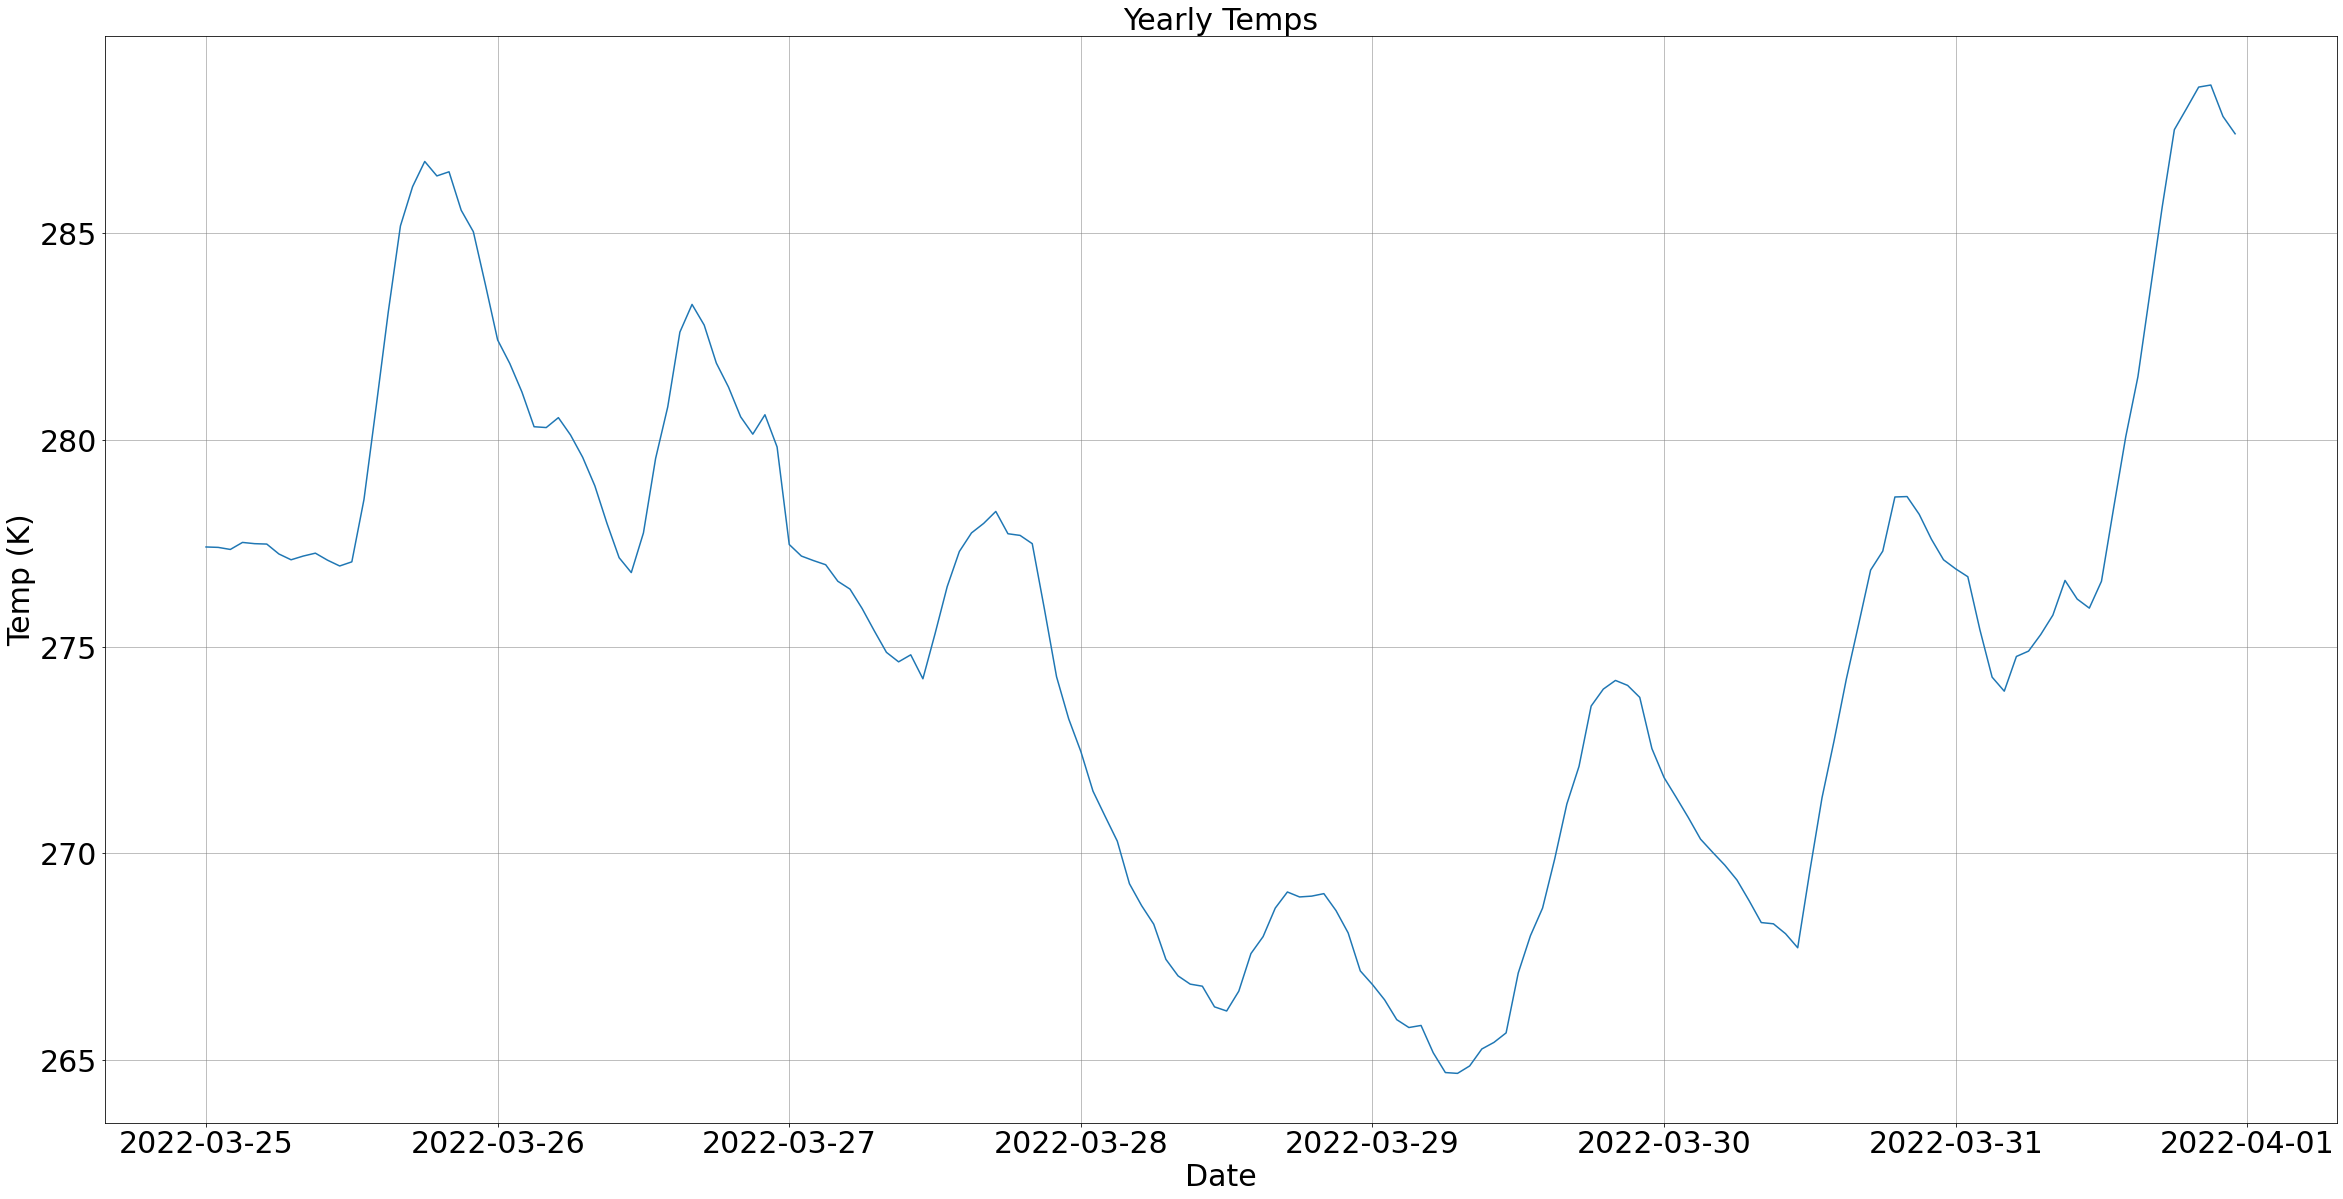

In [3]:
fig, ax = plt.subplots(1,1, figsize=(40, 20))
ax.plot(df.tail(168).index.values, df['temp'].tail(168)) #168 hours in a week
ax.set_title('Yearly Temps', fontsize=30)
ax.set_xlabel('Date', fontsize=30)
ax.set_ylabel('Temp (K)', fontsize=30)
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(axis="x", labelsize=30)
ax.tick_params(axis="y", labelsize=30)
plt.show() 

### There is clear seasonality over 24 hours.

### An Adfuller test is misleading here, with a P-value of 5.6479798438641e-11, suggesting that the data is stationary. However Adfuller does not account for seasonality.

In [4]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df['temp'].tail(8760*5), autolag='AIC')
print(dftest)

(-7.451709849895687, 5.647979843863788e-11, 55, 43744, {'1%': -3.430499498988984, '5%': -2.8616060752745827, '10%': -2.5668051697196077}, 99501.5715807156)


### We can prove this by plotting  an autocorrelation and partial autocorrelation plot of the data as it is.

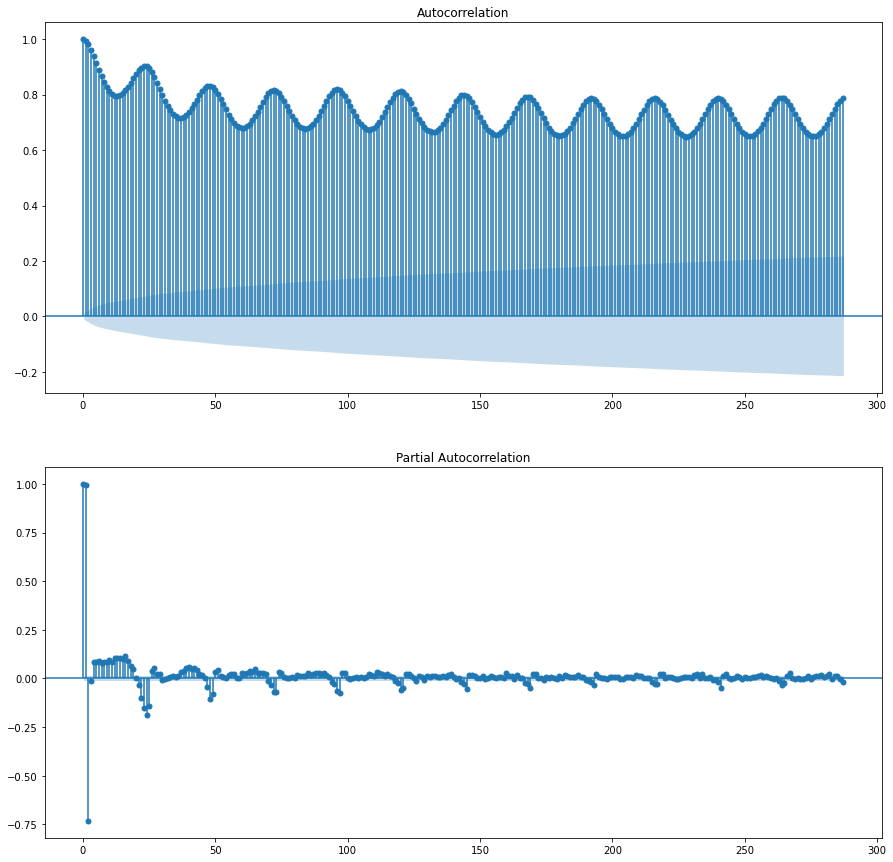

In [5]:
#autocorr and pcaf raw data
import statsmodels.api as sm
fig, ax = plt.subplots(2,1, figsize=(15,15))
fig = sm.graphics.tsa.plot_acf(df['temp'].tail(8760*3), lags=[i for i in range(24*12)], ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df['temp'].tail(8760*3), lags=[i for i in range(24*12)], ax=ax[1])
plt.show()

### The autocorrelation plot does not converge, and the data is not stationary.

### To make the data stationary a 24 hour difference is enough. 

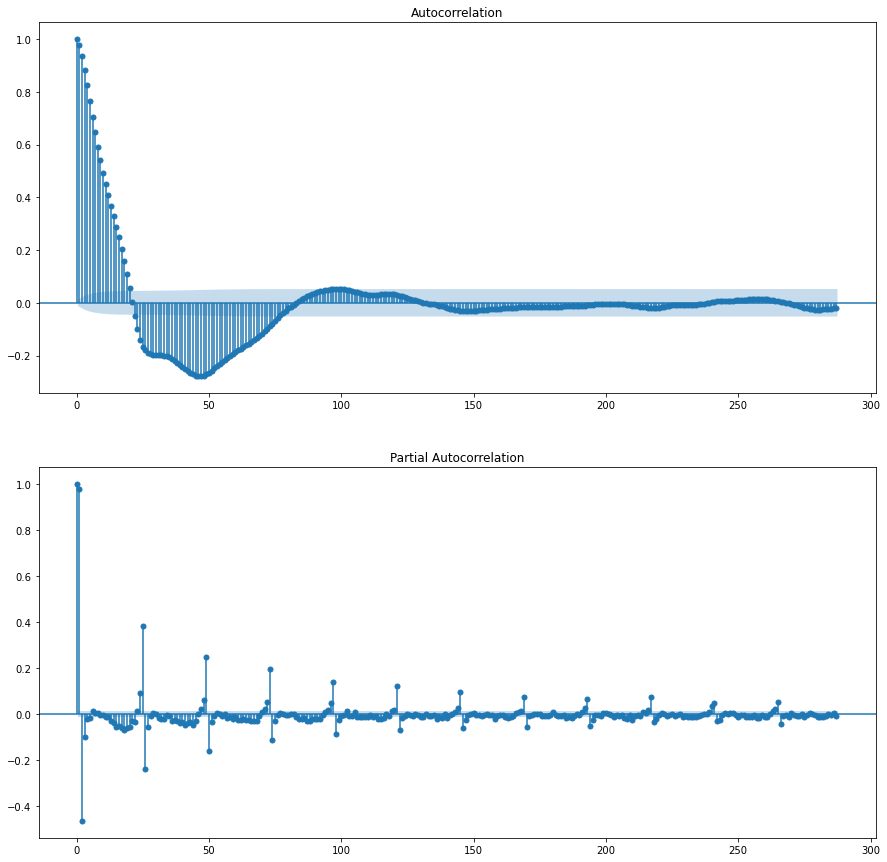

In [6]:
#autocorr and pcaf, seasonal
data_acf = df['temp'] - df.shift(24)['temp']
import statsmodels.api as sm
fig, ax = plt.subplots(2,1, figsize=(15,15))
fig = sm.graphics.tsa.plot_acf(data_acf.tail(8760*3), lags=[i for i in range(24*12)], ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(data_acf.tail(8760*3), lags=[i for i in range(24*12)], ax=ax[1])
plt.show()

### As seen the ACF plot, the series converges, so it is now stationary. The ACF plot crosses a threshold at around 20 hours. This implies that for the non seasonal component, the temperature of any day is significantly dependent on the temperatures for the last 20 hours. Also it is clear in the PACF plot that a lag spike occurs every 24 hours, confirming the 24 hour seasonality. These spikes become insignificant after around 6 seasonal lags. During time series modeling all of this suggests to use seasonal first order differencing D=1, with a season of 24 hours, m=24, a nonseasonal lag p of 20 hours, and a seasonal lag of around 6 days. Also d=0 since the series becomes stationary with seasonal differencing alone, as seen in the next plots.

### Lets plot the time differenced data and see what it looks like now.

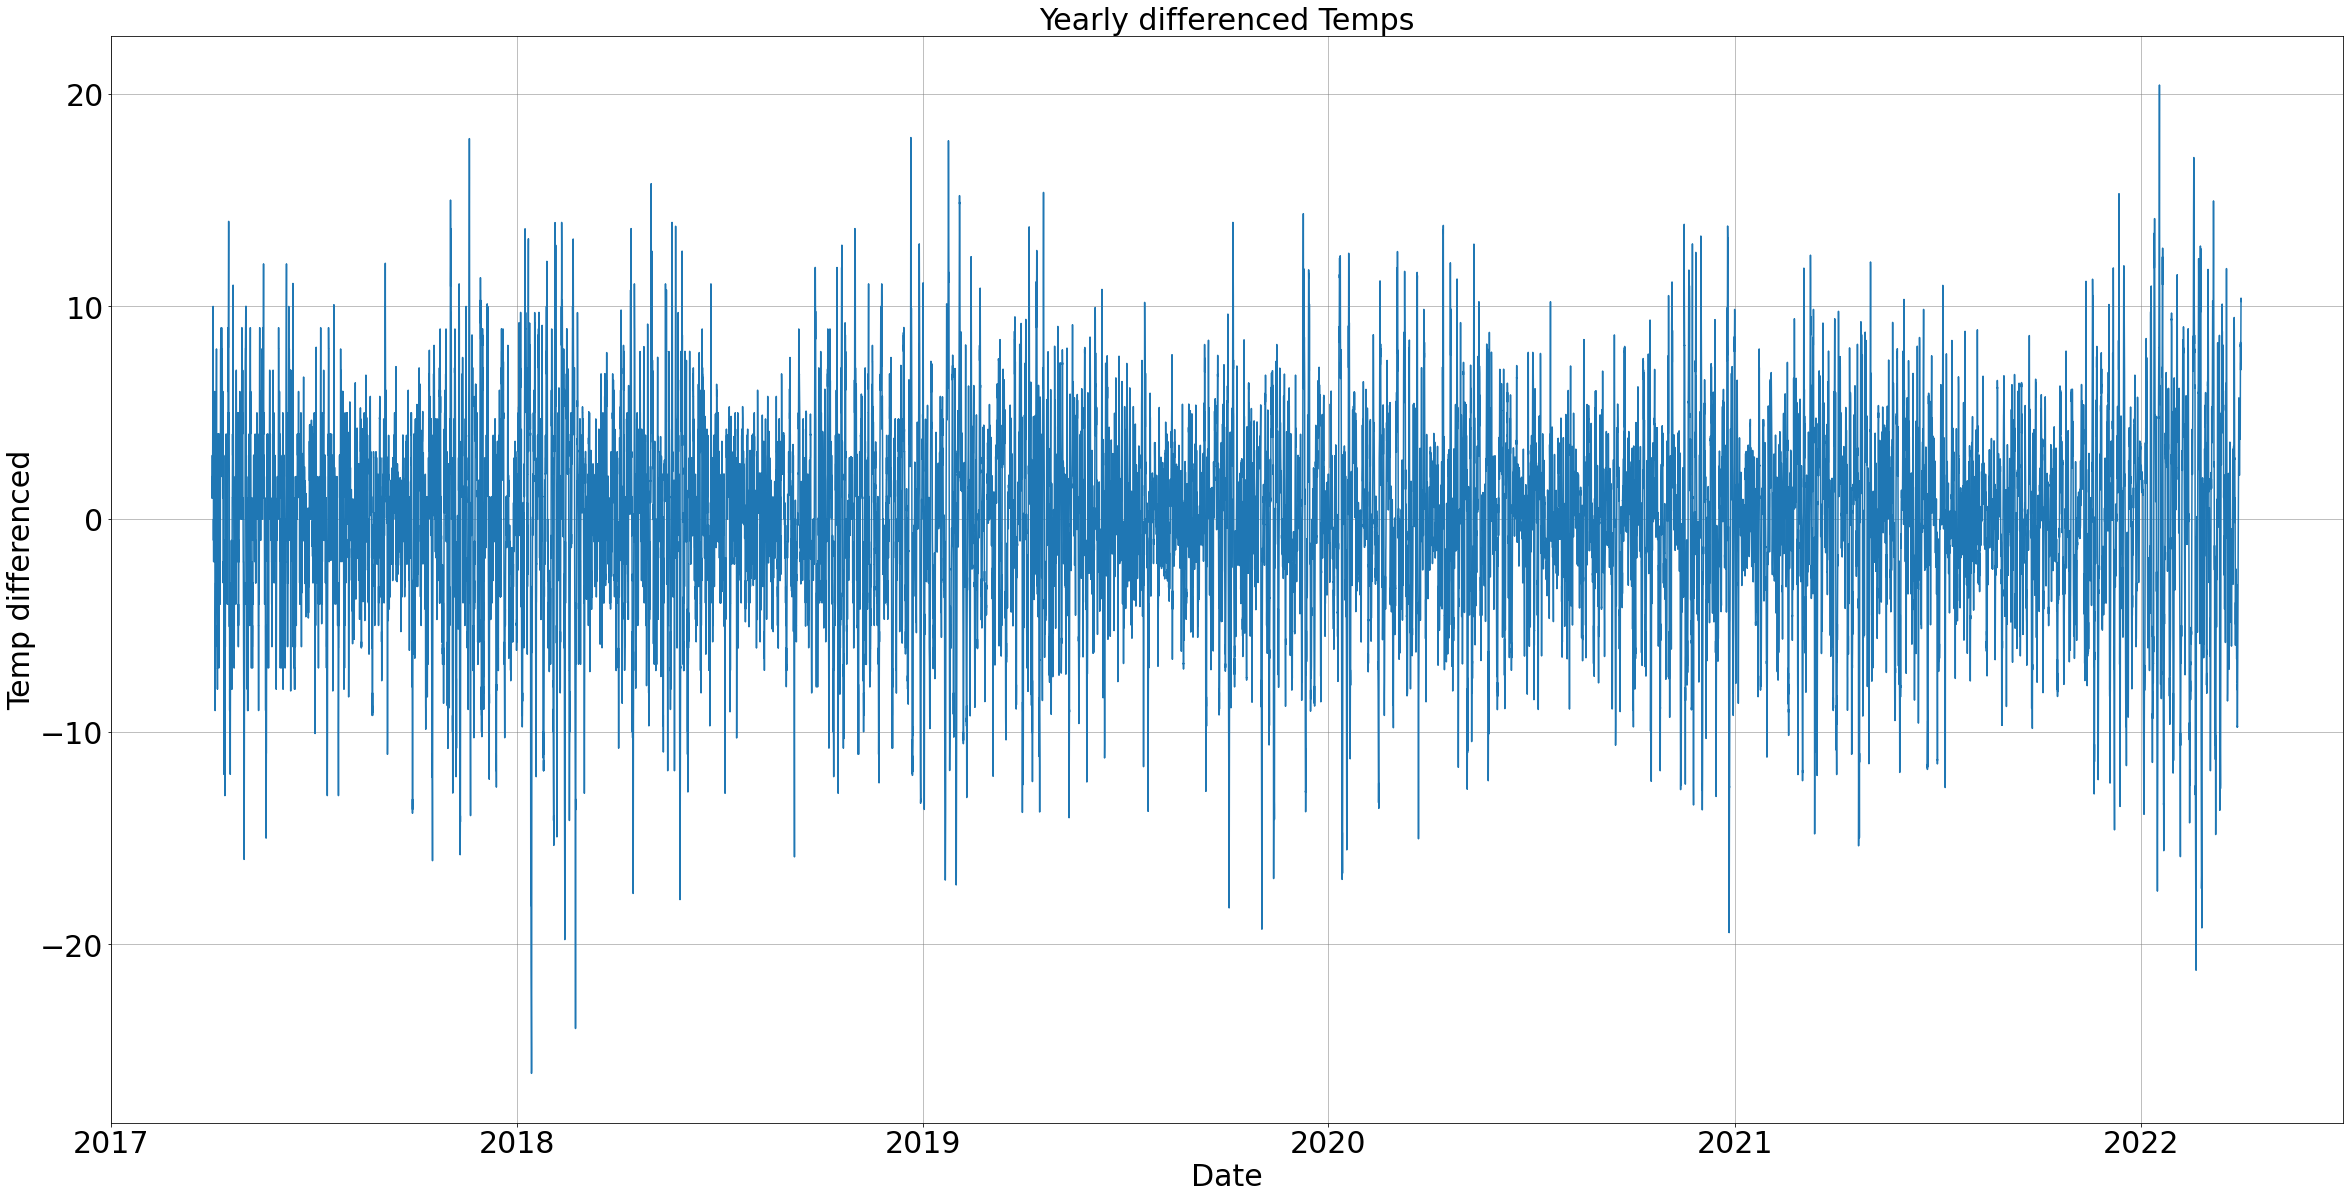

In [7]:
fig, ax = plt.subplots(1,1, figsize=(40, 20))
ax.plot(data_acf.tail(8760*5).index.values, data_acf.tail(8760*5)) #8760 hours in a year
ax.set_title('Yearly differenced Temps', fontsize=30)
ax.set_xlabel('Date', fontsize=30)
ax.set_ylabel('Temp differenced', fontsize=30)
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(axis="x", labelsize=30)
ax.tick_params(axis="y", labelsize=30)
plt.show() 

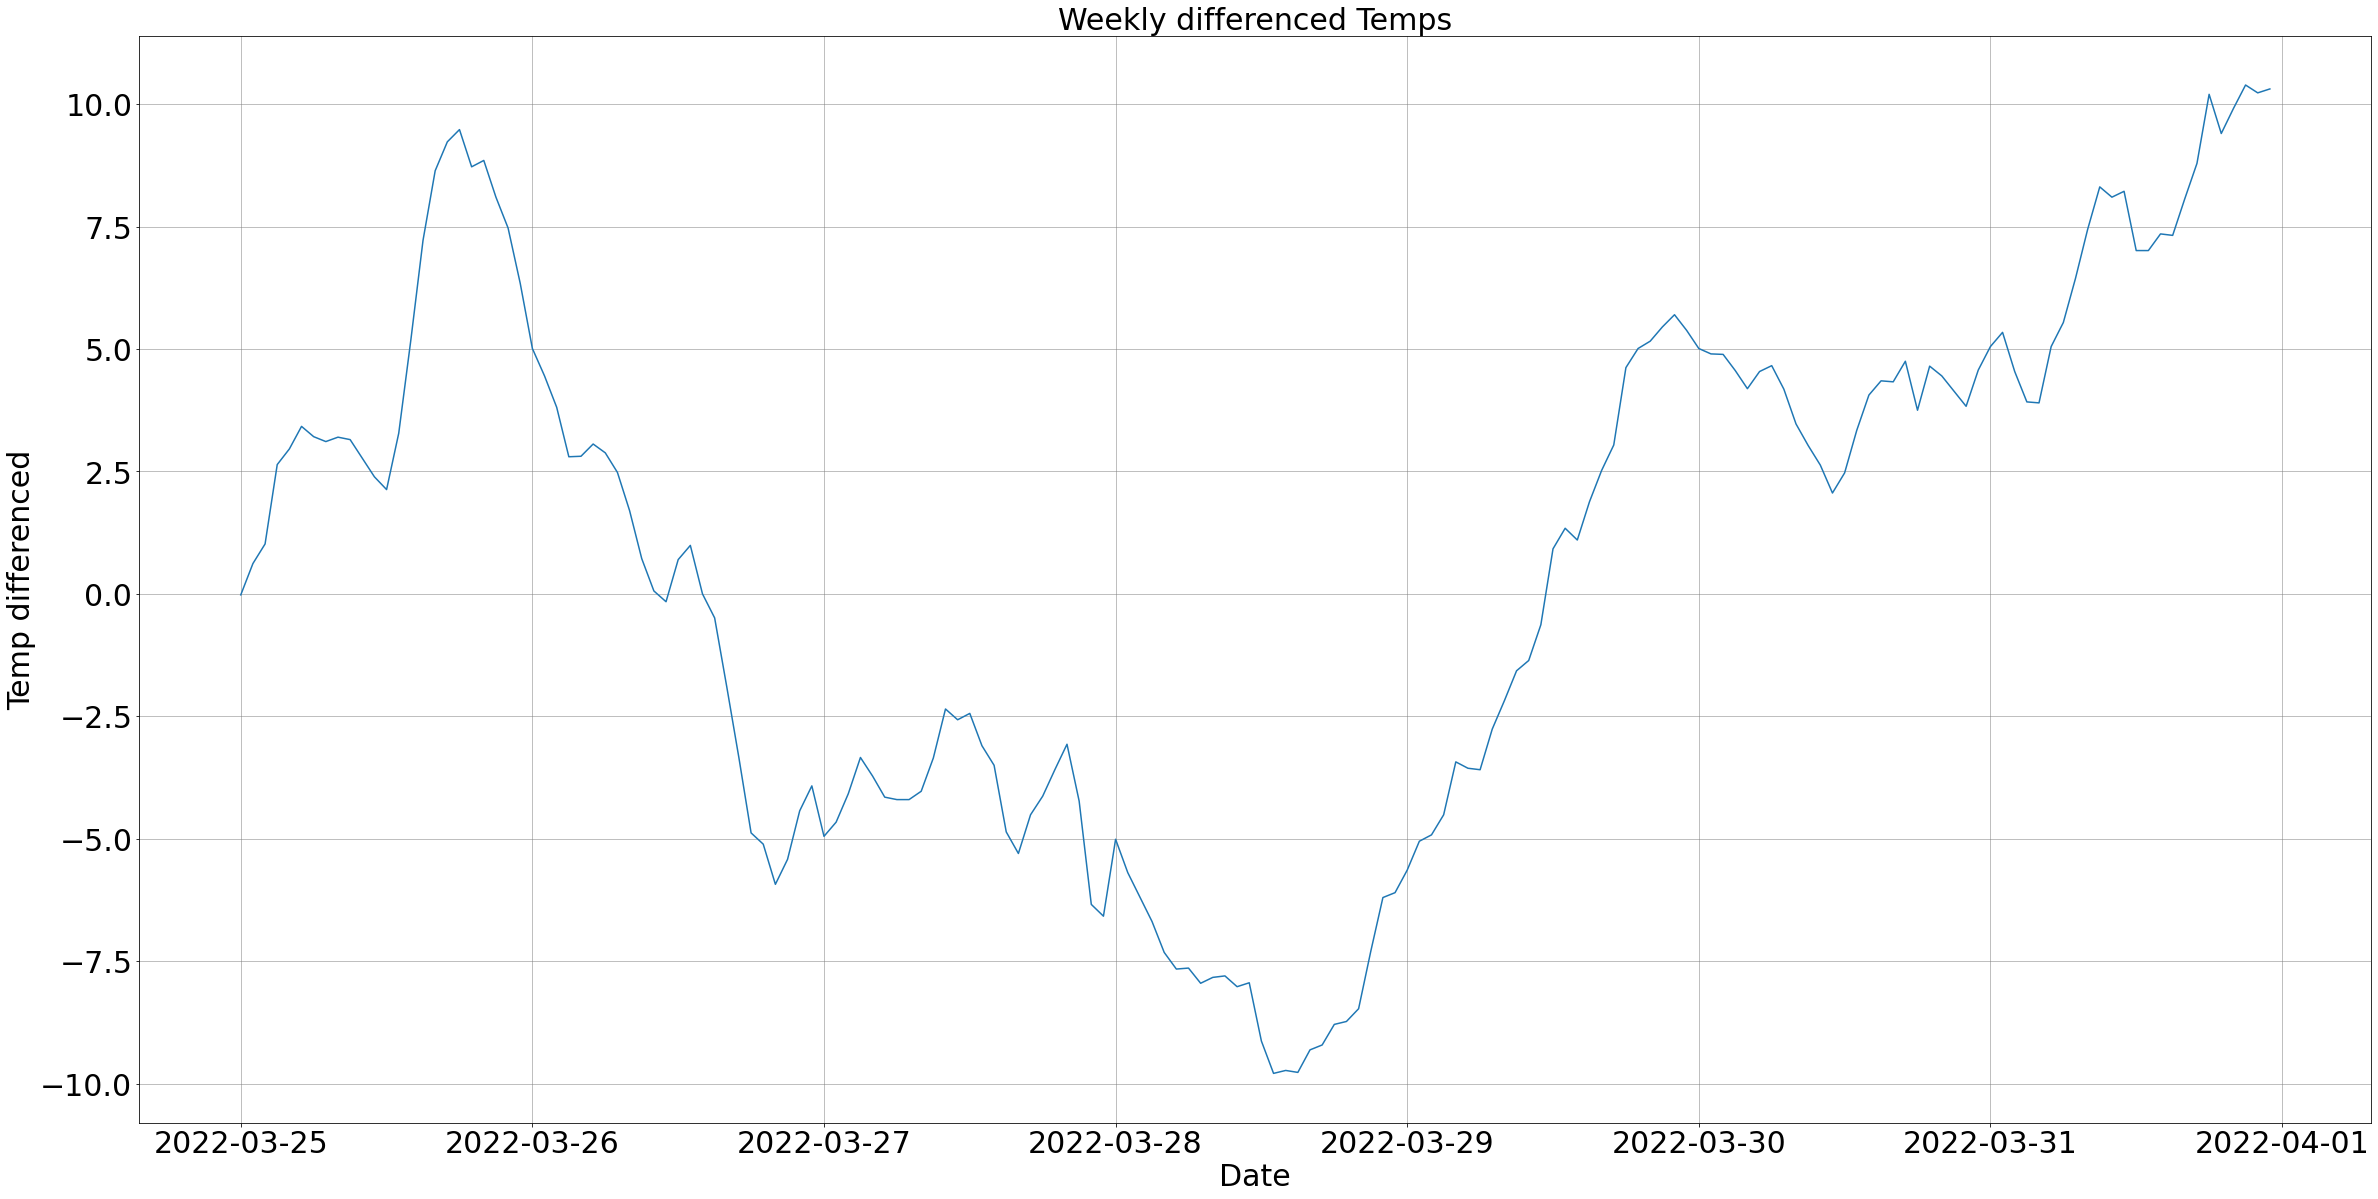

In [8]:
fig, ax = plt.subplots(1,1, figsize=(40, 20))
ax.plot(data_acf.tail(168).index.values, data_acf.tail(168)) #8760 hours in a year
ax.set_title('Weekly differenced Temps', fontsize=30)
ax.set_xlabel('Date', fontsize=30)
ax.set_ylabel('Temp differenced', fontsize=30)
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(axis="x", labelsize=30)
ax.tick_params(axis="y", labelsize=30)
plt.show() 

### We have succesfully removed the daily seasonality from the data .

### Now I will let a seasonal auto Arima decide the best parameters, which hopefully will agree with the analysis. This will also suggest the best seasonal(Q) and non seasonal(q) moving average parameters to use. For this section I split the data into 6 hour intervals in order train faster.

In [9]:
datat = df['temp']
datat.columns = ['temp']

#### In this section I run auto Arima with stepwise = false so that every combination of parameters is used. On top of splitting the data into 6 hour intervals, I also only train this part on one month of data.

In [21]:
auto_data1 = datat.tail(730) #one month
auto_data1 = auto_data1[::6] #every 6th hour

from pmdarima import auto_arima
# auto_arima(auto_data1, seasonal=True, m=4, trace=True, max_P=7, max_p=7, max_Q=3, max_q=3, D=1, max_d=1, max_order=None, 
#            stepwise=False).summary()

### Best model:  ARIMA(3,0,2)(1,1,3)[4] intercept
### Total fit time: 416.751 seconds

#### In this section I run auto Arima with stepwise = True which will not attempt to use every combination of parameters, but instead chooses them in an intelligent step wise manner. Now I can train on three years of data without taking all day.

In [22]:
auto_data1 = datat.tail(8760*3) #three years
auto_data1 = auto_data1[::6] #every 6th hour

from pmdarima import auto_arima
# auto_arima(auto_data1, seasonal=True, m=4, trace=True, max_P=7, max_p=7, max_Q=3, max_q=3, D=1, max_d=1, max_order=None, 
#            stepwise=True).summary()

### Best model:  ARIMA(3,0,3)(4,1,1)[4]          
### Total fit time: 676.109 seconds

### On average Auto Arima selected parameters (3,0,2)(4,1,2)[4], which corresponds to  (18,0,12)(4,1,2)[24] when we adjust for the 6 hour intervals used to train. This confirms the earlier parameters suggested in the acf/pacf analysis. So, for the both the SARIMA and seasonal VAR models later in the notebook, I will be using these parameters: (18,0,12)(4,1,2)[24], which I will adjust based on if I split data for training to fit the same time scales.

### Lets now create a k Nearest Neighbors model, which will classify any hour of the day as rainy based on whether days with the same conditions produced rain. 

### Note that I had included features based on wind speed and direction : 'wind_speed', 'wind_EW', 'wind_NS', 

### where :

In [12]:
#df['wind_NS'] = np.sin(np.deg2rad(df['wind_deg']))
# and  
# df['wind_EW'] = np.cos(np.deg2rad(df['wind_deg']))

### But during back and forth optimization of the gridsearch and sequential feature selector below, these features were not chosen to optimize the knn model for f1 score.

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

### Feature Creation

In [14]:
data1 = df[['temp', 'pressure', 'humidity']]

diff = data1.diff(periods=72)
diff.columns = ['dtemp', 'dpressure', 'dhumidity'] #change in temp, pressure, humidity

data1 = pd.concat([data1, diff], axis=1)

data1=(data1-data1.min())/(data1.max()-data1.min()) #normalizing for knn

weather_dum = pd.get_dummies(df['weather_main'], drop_first=False) #making dums to classify conditions

### Grid search for best parameters to use. The performance metric was chosen as f1 score, since the weather condition "Rain" is class imbalanced, rare, and it is equally disappointing to cancel plans because of rain as it is to expect a dry day and get rained on.

In [15]:
chosen_data = data1[['temp', 'pressure', 'humidity', 'dtemp', 'dpressure', 'dhumidity']]
neighbors = [8, 10, 15]
weights = ["uniform", "distance"]
#algo = ["ball_tree", "kd_tree", "brute"]
metric = ["euclidean", "minkowski", "hamming"]

grid_knn = {'n_neighbors': neighbors,
            'weights': weights,
            #'algorithm': algo,
            'metric': metric}

search_knn = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = grid_knn, scoring='f1')

knn_best_params = search_knn.fit(data1.tail(8760*3), weather_dum['Rain'].tail(8760*3))

print('best params:', knn_best_params.best_params_)

best params: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}


### Sequential feature selector to decide which of the features to use based on the parameters chosen above.

In [16]:
# print(data1)
# print(data1[data1.isna().any(axis=1)])
#//////////////// BFS /////////////////////////////////
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedKFold


sfs_score_listf = []
sfs_score_listb = []


for i in [3, 4, 5]: #Try these many features (I had already tried a larger range)
    

    sfs_backward_log = SequentialFeatureSelector(KNeighborsClassifier(n_neighbors=10, weights='distance', metric='euclidean'), n_features_to_select=i,
                                                 direction='backward', scoring='f1').fit(data1.tail(8760*7),
                                                                                               weather_dum['Rain'].tail(8760*7))

    
    mask_allb_log = sfs_backward_log.get_support()
    features_allb_log = data1.tail(8760*7).columns[mask_allb_log]
    features_allb_log = np.asarray(features_allb_log) 
    # print(features_allb_log)
    
    sfs_backward_log = sfs_backward_log.transform(data1.tail(8760*7))
    
    sfs_backward_log = pd.DataFrame(sfs_backward_log)
    
    sfs_backward_log.columns = features_allb_log

    
    #     print(sfs_backward_log)

    
    clf_log_b_filt_cv = KNeighborsClassifier(n_neighbors=8, weights='distance', metric='euclidean')
    Scoring = 'f1'
    
    cv_scores_b = cross_validate(clf_log_b_filt_cv, sfs_backward_log, weather_dum['Rain'].tail(8760*7),
                                 cv=StratifiedKFold(n_splits=3, shuffle=True),
                                 scoring=Scoring)
    print(cv_scores_b)
    
    

    f1_score_mean_b = np.mean(cv_scores_b['test_score'])
    
    sfs_score_listb.append(f1_score_mean_b)



print(sfs_score_listb)
print(sfs_backward_log.columns)

{'fit_time': array([0.03300047, 0.03100133, 0.03100085]), 'score_time': array([0.09199929, 0.09099889, 0.08799958]), 'test_score': array([0.43465614, 0.42227764, 0.4269802 ])}
{'fit_time': array([0.03899956, 0.03800011, 0.03800011]), 'score_time': array([0.15400004, 0.15499902, 0.15300035]), 'test_score': array([0.51359767, 0.51099692, 0.5117361 ])}
{'fit_time': array([0.0459981 , 0.046     , 0.04400015]), 'score_time': array([0.28300047, 0.2919991 , 0.27799916]), 'test_score': array([0.57714521, 0.57556936, 0.57811852])}
[0.42797132562563495, 0.512110229360003, 0.5769443657858693]
Index(['temp', 'pressure', 'humidity', 'dtemp', 'dhumidity'], dtype='object')


### Lets do a cross validation now over the 40 years of data to check our final f1 score with the chosen features and parameters.

In [17]:
chosen = data1[['temp', 'pressure', 'humidity', 'dtemp', 'dpressure', 'dhumidity']]

clf_knn_cv = KNeighborsClassifier(n_neighbors=10, weights='distance', metric='euclidean')

Scoring = 'f1'
cv_scores = cross_validate(clf_knn_cv, chosen.tail(8760*35), weather_dum['Rain'].tail(8760*35),
                             cv=StratifiedKFold(n_splits=10, shuffle=True), scoring = Scoring, return_train_score=False)

f1_score_mean = np.mean(cv_scores['test_score'])
print('knn f1 = ', f1_score_mean) 


knn f1 =  0.6190573735137695


### Not bad considering we did not account for month or time of day and only considered raw data (temp/pressure/humidity) and their rates of change. I did not bother to search for better performing models at this time, as this will give us a baseline to decide whether it will be possible to apply any rain classifying model to the time series forecasted data and achieve results with any degree of desirable performance.

## Time Series Modeling

### SARIMA

### Based on the ACF and PACF plots in previous section the ideal seasonal parameters for SARIMA would be (18,0,12)(4,1,2)[24] . I split the data into 4 hour intervals here to train faster, so the parameters are changed to: (5,0,3)(4,1,2)[6]

c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


rmse value is T:  5.912590692845019


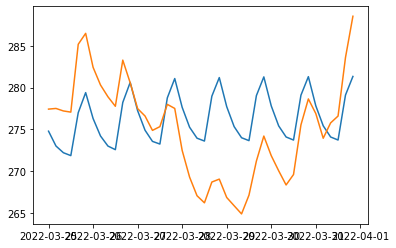

c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


rmse value is T:  6.565337446574535


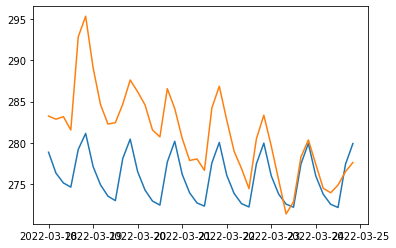

c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  warnings.warn('No frequency information was'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


rmse value is T:  6.137052512226925


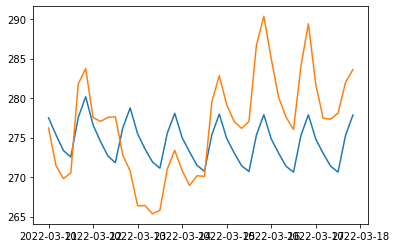

sarima_rmse_avg 6.204993550548825


In [18]:
datasrma = df['temp']
datasrma.columns = ['temp']
datasrma = datasrma.tail(37000) #about 4 years of training data for sarima





datasrma = datasrma[::4] #every 4 hours, and 168 hrs in a week becomes 42 steps


sarima_rmse = []
#trainlist = [-42*(t+1) for t in range(15)]
trainlist = [-42, -42*2, -42*3]
for i in trainlist:
    train = datasrma[:i]  
    # print('train', train, 'train')
    if i == -42:
        valid2t = datasrma[i:]  #if else to get around [i,0], doesnt like 0
    else:
        valid2t = datasrma[i:i + 42]

    from statsmodels.tsa.statespace.sarimax import SARIMAX
    smax = SARIMAX(endog=train.tail(2190*35), order=(5, 0, 3), seasonal_order=(4, 1, 2, 6)).fit()

    prediction = smax.forecast(steps=len(valid2t))


    pd.set_option("display.max_rows", None, "display.max_columns", None)

    preds = pd.DataFrame(prediction) #pred
    preds.columns = ['temp']
#     print(preds)



    Fcast_T = preds['temp'] #was adjusted
    predval = pd.concat([Fcast_T, valid2t], axis=1)

    predval.columns = ['Tpred', 'T']
#     print(predval.head(25))
    # print(predval.columns)



    # print(Fcast_T)
    # print(valid2)
    rmse = math.sqrt(mean_squared_error(Fcast_T.to_numpy(), valid2t.to_numpy()))
    print('rmse value is T: ', rmse)
    sarima_rmse = np.append(sarima_rmse, rmse)


    plt.plot(predval.index.values, predval['Tpred']) 
    plt.plot(predval.index.values, predval['T']) 
    plt.show()
#     print(sarima_rmse)


sarima_rmse_avg = np.mean(sarima_rmse)
print('sarima_rmse_avg', sarima_rmse_avg)

### Above are the plots of temperature predictions vs actual predictions for 3 weeks of data, along with the RMSE for that week, and the average over three weeks.

### For 3 months of predictions, the rmse was:  sarima_rmse_avg =  5.897

## Seasonal VAR

### Now we try a multivariate time series to see if adding modeling pressure and humidity together with temperature can increase the accuracy of hourly temperature predictions.

### There is no seasonal package in statsmodels for VAR. Instead, I had to manually difference the data before fitting, and then reverse the transformation on predictions. Statsmodels VARMAX, which includes a moving average component, proved to take too long to fit, so I stuck with VAR.

In [19]:
#/////////////////////differencing//////////////////////////
df['deltaT_d'] = df['temp'] - df.shift(24)['temp']
df['deltaP_d'] = df['pressure'] - df.shift(24)['pressure']
df['deltaH_d'] = df['humidity'] - df.shift(24)['humidity']
df['deltaW_d'] = df['wind_speed'] - df.shift(24)['wind_speed']


data1 = df[['deltaT_d', 'deltaP_d', 'deltaH_d', 'deltaW_d']] 


data1 = data1.tail(8760*35)

### Train and test seasonal VAR for three weeks like with SARIMA

c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\base\wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


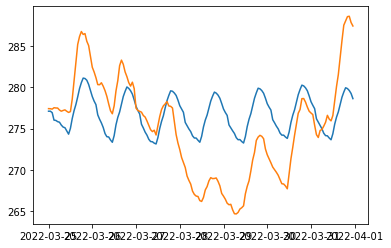

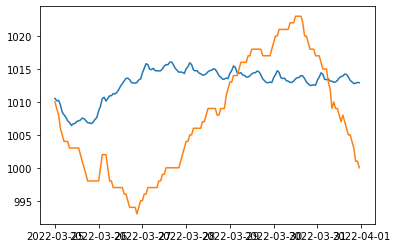

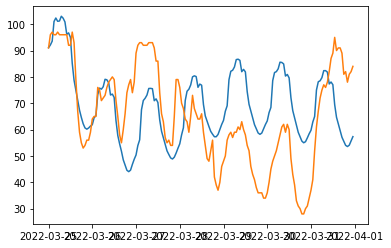

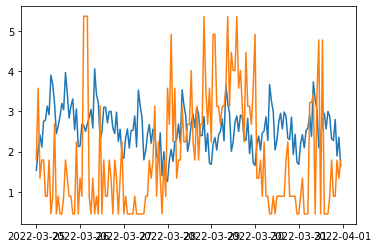

c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\base\wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


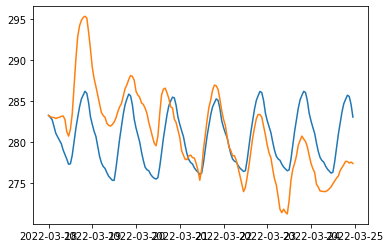

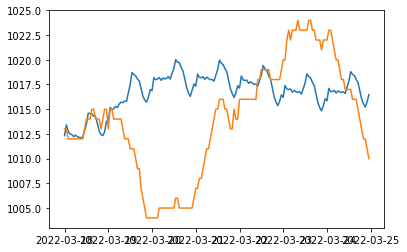

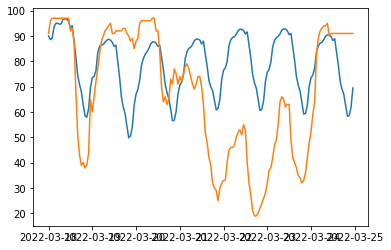

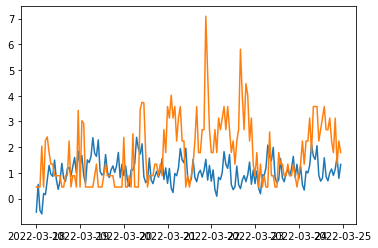

c:\users\dave\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
c:\users\dave\miniconda3\lib\site-packages\statsmodels\base\wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


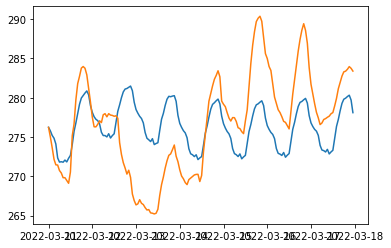

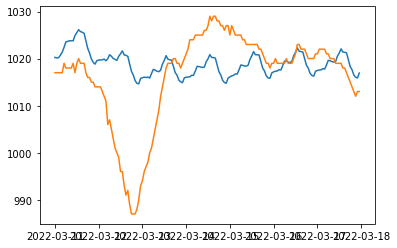

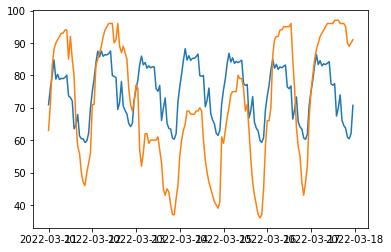

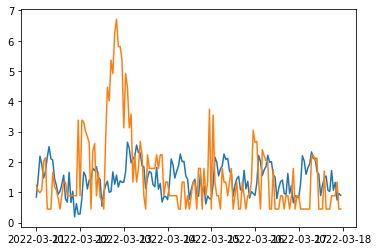

rmseavgT =  5.27658133039591
rmseavgP =  9.013932712200456
rmseavgH =  20.508298156047818
rmseavgW =  1.5260101635516463
f1_score_rain_avg =  0.1212121212121212


In [20]:
# print(data1)
#/////////////////////////////////////////////

svar_rmseT = []
svar_rmseP = []
svar_rmseH = []
svar_rmseW = []
f1_score_rain = []
#trainlist = [-168*(t+1) for t in range(15)]
trainlist = [-168, -168*2, -168*3] #168 hours in a week. We train up to that week, then make predictions, for every 
                                                                                                #week in this list.

#If no rain occured, KeyError: 'Rain' week_test = week_weather_dum['Rain'], becuase no rain in valid2r

for i in trainlist:
    #creating the train and validation set
    train = data1[:i] 
    # print('train', train, 'train')
    if i == -168:
        valid = data1[i:]   #if else to get around [i,0], doesnt like 0
        valid2t = df['temp'][i:]
        valid2p = df['pressure'][i:]
        valid2h = df['humidity'][i:]
        valid2w = df['wind_speed'][i:]
        valid2r = df['weather_main'][i:]
        # valid2ew = df['wind_EW'][i:]
        # valid2ns = df['wind_NS'][i:]
    else:
        valid = data1[i:i+168]
        valid2t = df['temp'][i:i+168]
        valid2p = df['pressure'][i:i+168]
        valid2h = df['humidity'][i:i+168]
        valid2w = df['wind_speed'][i:i+168]
        valid2r = df['weather_main'][i:i+168]
        # valid2ew = df['wind_EW'][i:i+168]
        # valid2ns = df['wind_NS'][i:i+168]

    # print('valid', valid, 'valid')

    # fit the model
    from statsmodels.tsa.vector_ar.var_model import VAR
    from statsmodels.tsa.statespace.varmax import VARMAX
    trained_model = VAR(endog=train)
    model_fit = trained_model.fit(72) #75 looking good



    prediction = model_fit.forecast(model_fit.y, steps=len(valid))
    # print(prediction, len(prediction))

    #each list represents the predictions of the row.
    # We will transform this into a more presentable format.

    cols = data1.columns
    #converting predictions to dataframe
    pred = pd.DataFrame(index=range(0, len(prediction)), columns=[cols])
    # print('pred', pred, 'pred')
    for j in range(0, 4):
        for x in range(0, len(prediction)):
           pred.iloc[x][j] = prediction[x][j]




    import numpy as np
    # print('pred2', pred, 'pred2')
    pd.set_option("display.max_rows", None, "display.max_columns", None)

    preds = pd.DataFrame(pred)


    #here un_tform refers to the predictions after reverse transformation


    un_tform_T = []
    for j in range(24):  
        exp = df['temp'][-24 + i + j] + preds['deltaT_d'].iloc[j] #range 24 matches with preds
        un_tform_T = np.append(un_tform_T, exp)

    for j in range(168-24):
        exp = un_tform_T[j] + preds['deltaT_d'].iloc[24+j] 
        un_tform_T = np.append(un_tform_T, exp)



    un_tform_P = []
    for j in range(24):  
        exp = df['pressure'][-24 + i + j] + preds['deltaP_d'].iloc[j]  # range 24 matches with preds
        un_tform_P = np.append(un_tform_P, exp)

    for j in range(168 - 24):
        exp = un_tform_P[j] + preds['deltaP_d'].iloc[24 + j] 
        un_tform_P = np.append(un_tform_P, exp)

        

    un_tform_H = []
    for j in range(24):  
        exp = df['humidity'][-24 + i + j] + preds['deltaH_d'].iloc[j]  # range 24 matches with preds
        un_tform_H = np.append(un_tform_H, exp)

    for j in range(168 - 24):
        exp = un_tform_H[j] + preds['deltaH_d'].iloc[24 + j]  # last ended at 23 and j starts from 0
        un_tform_H = np.append(un_tform_H, exp)

        
    un_tform_W = []
    for j in range(24):  
        exp = df['wind_speed'][-24 + i + j] + preds['deltaW_d'].iloc[j]  # range 24 matches with preds
        un_tform_W = np.append(un_tform_W, exp)

    for j in range(168 - 24):
        exp = un_tform_W[j] + preds['deltaW_d'].iloc[24 + j]  
        un_tform_W = np.append(un_tform_W, exp)



    #Here Fcast_T/P/H/W is just dataframe'd reverse-transformed predictions

    Fcast_T = pd.DataFrame(un_tform_T) 
    Fcast_T.set_index(valid.index.values, inplace=True)

    Fcast_P = pd.DataFrame(un_tform_P) 
    Fcast_P.set_index(valid.index.values, inplace=True)

    Fcast_H = pd.DataFrame(un_tform_H) 
    Fcast_H.set_index(valid.index.values, inplace=True)

    Fcast_W = pd.DataFrame(un_tform_W) 
    Fcast_W.set_index(valid.index.values, inplace=True)





    predval = pd.concat([Fcast_T, Fcast_P, Fcast_H, Fcast_W, valid2t, valid2p,  #combine predictions/validation into one df
                         valid2h, valid2w], axis=1)
    predval.columns = ['Tpred', 'Ppred', 'Hpred', 'Wpred', 'T', 'P', 'H', 'W'] 
    # print(predval.head(25))
    # print(predval.columns)



    # print(Fcast_T)
    # print(valid2)
    rmse_T = math.sqrt(mean_squared_error(Fcast_T.to_numpy(), valid2t.to_numpy()))
    rmse_P = math.sqrt(mean_squared_error(Fcast_P.to_numpy(), valid2p.to_numpy()))
    rmse_H = math.sqrt(mean_squared_error(Fcast_H.to_numpy(), valid2h.to_numpy()))
    rmse_W = math.sqrt(mean_squared_error(Fcast_W.to_numpy(), valid2w.to_numpy()))

    svar_rmseT = np.append(svar_rmseT, rmse_T)
    svar_rmseP = np.append(svar_rmseP, rmse_P)
    svar_rmseH = np.append(svar_rmseH, rmse_H)
    svar_rmseW = np.append(svar_rmseW, rmse_W)

#     print('rmse value is T: ', rmseT)
#     print('rmse value is P: ', rmseP)
#     print('rmse value is H: ', rmseH)
#     print('rmse value is W: ', rmseW)

    plt.plot(predval.index.values, predval['Tpred']) 
    plt.plot(predval.index.values, predval['T']) 
    plt.show()

    plt.plot(predval.index.values, predval['Ppred']) 
    plt.plot(predval.index.values, predval['P']) 
    plt.show()

    plt.plot(predval.index.values, predval['Hpred']) 
    plt.plot(predval.index.values, predval['H']) 
    plt.show()
    #
    plt.plot(predval.index.values, predval['Wpred'])
    plt.plot(predval.index.values, predval['W']) 
    plt.show()

    #try to classify rain using the forecasted conditions:
    from sklearn.neighbors import KNeighborsClassifier
    
    matchcol = predval[['Tpred', 'Ppred', 'Hpred']]
    matchcol.columns = ['temp', 'pressure', 'humidity']
    predtrain = df[['temp', 'pressure', 'humidity']][:i].append(matchcol)
    # print(predtrain)
    
    diff = predtrain.diff(periods=72)
    diff.columns = ['dtemp', 'dpressure', 'dhumidity']
    
    data2 = pd.concat([predtrain, diff], axis=1) #same length as original df so i should match
    data2 = (data2 - data2.min()) / (data2.max() - data2.min())
    
    weather_dum = pd.get_dummies(df['weather_main'], drop_first=False)
    
    week_weather_dum = pd.get_dummies(valid2r, drop_first=False)
    week_test = week_weather_dum['Rain']  
    
    knn = KNeighborsClassifier(n_neighbors=8, weights='distance', metric='euclidean').fit(data2[:i].tail(8760*35),
                                                                                                weather_dum['Rain'][:i].tail(8760*35))
    
    week_pred = knn.predict(data2.tail(168))
    # from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.metrics import f1_score
    f_score = f1_score(week_test, week_pred)
    f1_score_rain = np.append(f1_score_rain, f_score)
    
    


    # plt.show()


svar_rmse_avgT = np.mean(svar_rmseT)
svar_rmse_avgP = np.mean(svar_rmseP)
svar_rmse_avgH = np.mean(svar_rmseH)
svar_rmse_avgW = np.mean(svar_rmseW)
f1_score_rain_avg = np.mean(f1_score_rain)

print('rmseavgT = ', svar_rmse_avgT)
print('rmseavgP = ', svar_rmse_avgP)
print('rmseavgH = ', svar_rmse_avgH)
print('rmseavgW = ', svar_rmse_avgW)
print('f1_score_rain_avg = ', f1_score_rain_avg)


### Above are the plots of predictions vs actual temperatures for the last few weeks of data. The RMSE over 3 months was:   

### rmseavgT =  5.607199279831017
### rmseavgP =  9.092295869158045
### rmseavgH =  17.142480595062903
### rmseavgW =  1.3142526936427532


### This outperforms the SARIMA model which only models temperature alone. This is an interesting result, but it is clear that hourly weather conditions are influenced by factors not explained by time series as I’ve built them, and multivariate VAR only helps slightly to account for them.


### The f1 score for classifying rain conditions from forecasted data was very poor. The hope was that a multivariate time series may be able to forecast a convergence of weather conditions (temp, pressure, humidity) that could cause rain. The conditions for rain are very specific, and daily hourly temperatures are prone to shifts not explained by time series alone.  Therefore a time series alone as I’ve built it does not show much potential for forecasting weather condition events outside of general conditions like temperature and humidity.